  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


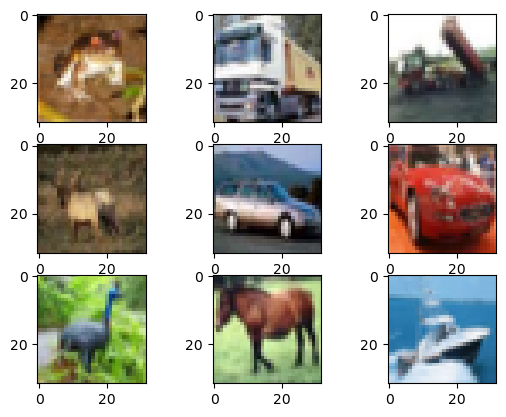

In [1]:
# 데이터 전처리
import matplotlib.pyplot as plt

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

# CIFAR-10 데이터셋 불러오기
train_data = CIFAR10(
    root='./',  # 내려받을 경로
    train=True,  # 트레인용
    download=True,  # 다운로드 받음
    transform=ToTensor()  # 이미지를 텐서로 변환
)

test_data = CIFAR10(
    root='./',
    train=False,
    download=True,
    transform=ToTensor()
)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_data.data[i])
plt.show()

Files already downloaded and verified
Files already downloaded and verified


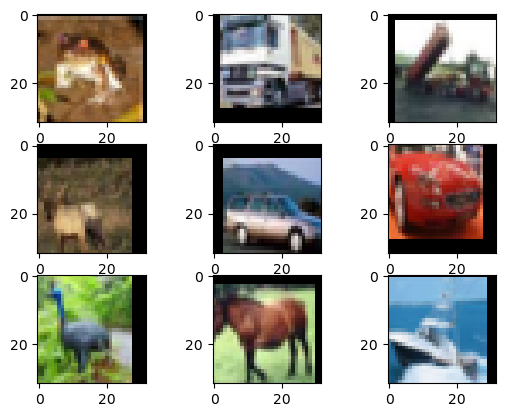

In [5]:
import torchvision.transforms as T
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

transforms = Compose([
    T.ToPILImage(),
    RandomCrop((32, 32), padding=4),  # 랜덤으로 크롭 후 패딩
    RandomHorizontalFlip(p=0.5),
])

train_data = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=transforms
)

test_data = CIFAR10(
    root='./',
    train=False,
    download=True,
    transform=transforms
)

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(transforms(train_data.data[i]))  # ? transforms() 해줘야 적용됨
plt.show()

Files already downloaded and verified
Files already downloaded and verified


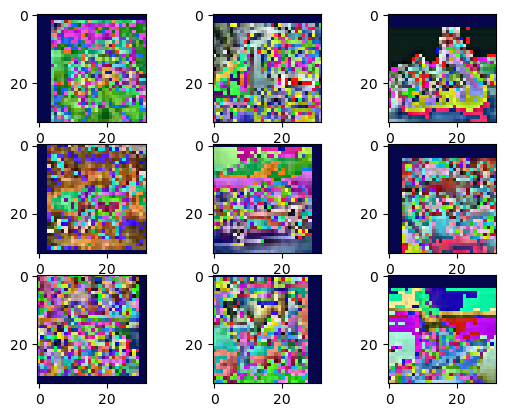

In [6]:
# 정규화
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize

transforms = Compose([
    T.ToPILImage(),
    RandomCrop((32, 32), padding=4),  # 랜덤으로 크롭 후 패딩
    RandomHorizontalFlip(p=0.5),
    ToTensor(),

    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    T.ToPILImage()
])

train_data = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=transforms
)

test_data = CIFAR10(
    root='./',
    train=False,
    download=True,
    transform=transforms
)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(transforms(train_data.data[i]))
plt.show()

In [7]:
# CIFAR10 데이터셋의 평균과 표준편차를 구하는 코드
import torch

train_data = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=ToTensor()
)
# item[0]은 이미지, item[1]은 정답 레이블
imgs = [item[0] for item in train_data]

# imgs를 하나로 합침
imgs = torch.stack(imgs, dim=0).numpy()

# rgb 각 평균
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r, mean_g, mean_b)

# rgb 각 표준편차
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r, std_g, std_b)


Files already downloaded and verified
0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


In [8]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):  # 기본 블록 정의
    # 기본 블록
    def __init__(self, in_channels, out_channels, hidden_dim):
        # nn.Module 클래스의 요소 상속
        super(BasicBlock, self).__init__()
        # 합성곱층 정의
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        # stride는 커널의 이동 거리
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):  # 기본 블록의 순전파 정의
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        return x

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # 합성곱 기본 블록 정의
        self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
        self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
        self.block3 = BasicBlock(in_channels=128, out_channels=256, hidden_dim=128)

        # 분류기 정의
        self.fc1 = nn.Linear(in_features=4096, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)

        # 분류기의 활성화 함수
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)  # 출력 모양: (-1, 256, 4, 4)
        x = torch.flatten(x, start_dim=1)  # 2차원 특징 맵을 1차원으로

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

In [10]:
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

transforms = Compose([
    RandomCrop((32, 32), padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

In [11]:
# 데이터 로드
train_data = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=transforms
)

test_data = CIFAR10(
    root='./',
    train=False,
    download=True,
    transform=transforms
)

# 데이터로더 정의
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

model = CNN(num_classes=10)

model.to(device)

Files already downloaded and verified
Files already downloaded and verified


CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

In [13]:
lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
# print(device)

for epoch in range(100):
    for data, label in train_loader:
        optim.zero_grad()

        preds = model(data.to(device))

        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()


    print(f'epoch: {epoch+1} loss: {loss.item()}')

torch.save(model.state_dict(), 'CIFAR.pth')

mps
epoch: 1 loss: 0.7446759939193726
epoch: 2 loss: 0.2728513181209564
epoch: 3 loss: 0.6446452736854553
epoch: 4 loss: 0.31760507822036743
epoch: 5 loss: 0.09232106059789658
epoch: 6 loss: 0.37992802262306213
epoch: 7 loss: 0.17206072807312012
epoch: 8 loss: 0.31929442286491394
epoch: 9 loss: 0.5953893065452576
epoch: 10 loss: 0.6369627714157104
epoch: 11 loss: 0.26710522174835205
epoch: 12 loss: 0.47017234563827515
epoch: 13 loss: 0.7326353192329407
epoch: 14 loss: 0.14674265682697296
epoch: 15 loss: 0.24529911577701569
epoch: 16 loss: 0.7543632984161377
epoch: 17 loss: 0.28438910841941833
epoch: 18 loss: 0.0586891733109951
epoch: 19 loss: 0.41403448581695557
epoch: 20 loss: 0.7398788928985596
epoch: 21 loss: 0.23841767013072968
epoch: 22 loss: 0.7554778456687927
epoch: 23 loss: 0.5748361349105835
epoch: 24 loss: 0.2553529739379883
epoch: 25 loss: 0.4173930287361145
epoch: 26 loss: 0.2812501788139343
epoch: 27 loss: 0.5234306454658508
epoch: 28 loss: 0.5404316186904907
epoch: 29 los

KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('CIFAR.pth', map_location=device))
num_corr = 0

with torch.no_grad():
    for data, label in test_loader:
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        # eq: ==의미, 예측과 라벨 값이 일치하면 1
        num_corr += corr

    print(f'Accuracy: {num_corr/len(test_data)}')